# Faster itterative methods for the Solution of the Laplace Equation

In this workbook we are going to look at Gauss-Siedel and SOR methods for the solution of the Laplace equations to see if we can make them faster. You will remember that in the last workbook we found that the Jacobi iteration was fastest (although it used a lot more itterations) because it could exploit the pipeline on the processor by using whole array opperations. 

Gauss-Seidel and SOR could not as they needed to wait for new results to be available from the pipeline.  This is because the scheme
$$u_O^{n+1}=\frac{1}{2(1+\beta^2)}(u_E^n+u_W^{n+1}+\beta^2(u_N^n+u_S^{n+1})).$$
needs the values of u(i-1,j) and u(i-1,j) to compute u(i,j).  

So while SOR use only 7% of the number of itterations of the Jacobi scheme it was 10 times slower!

To do something about this we are going to need to understand how arrays are stored in memory and what we can do to avoid waiting.

Before starting I'm going to load the libraries we want and define our Grid class:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid'''
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))

    def set_origin(self,x0,y0):
        self.origin = (x0, y0)
    
    def set_extent(self,x1,y1):
        self.extent = (x1, y1)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def __str__(self):
        # describe the object when asked to print it
        return 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)

## The test problem
Were going to use the same test problem as before:  

$$0=u_{xx}+u_{yy}$$
subject to the boundary conditions
$$\begin{align*}
u(x,0)&=0&0\le x\le 2 \\
u(x,1)&=0&0\le x\le 2 \\
u(0,y)&=0&0\le y \le 1\\
u(2,y)&=\sin 2\pi y&0\le y \le 1.
\end{align*}$$


In [2]:
def Example929(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_extent(2.0,1.0)
    mesh.generate()
    # now the RHS boundary condition
    mesh.u[:,-1]=np.sin(2*np.pi*mesh.y[:,-1])
    return mesh

Uniform 161x81 grid from (0.0, 0.0) to (2.0, 1.0).


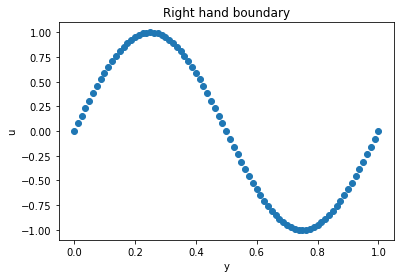

In [3]:
# lets test it
test = Example929(161,81)
print(test)

# and plot the boundary values.
plt.plot(test.y[:,-1],test.u[:,-1],'o')
plt.title('Right hand boundary')
plt.xlabel('y')
plt.ylabel('u')
plt.show()

## How are things stored?

Numpy will tell us a lot about how arrays are stored in memory.  The array object has some usefull properties that we can interogate.  We're going to look at the size, shape and strides of u.


In [4]:
print('size   :',test.u.size)
print('shape  :',test.u.shape)
print('strides:',test.u.strides)

size   : 13041
shape  : (81, 161)
strides: (1288, 8)


* size tells us that the array containts 13041 values.
* shape tells us it is an 81 by 161 array (stored as u[j,i])
* strides tells us that each element of u in the i direction is 8 bytes apart in memory and each in the j direction is 1288 bytes appart.  since 1288/8 = 161 we know that the array is stored with the i values contiguously.

I could now write the Gauss-Siedel scheme as:
$$u^{n+1}(k)=\frac1{2(1+\beta^2)}(u^n(k-1)+u^n(k+1)+\beta^2(u^n(k+161)+u^N(k-161))\, k=0 \ldots 1287$$
...  or almost since that would include the left, right, top and bottom boundary conditions! 

## where are the boundary conditions
We know that 
* the first 161 k values must contain the bottom boundary condition values,
* the last 161 k values must contain the top boundary condition values,
* k=0, 161, 322, 483, ... 161n ... 12880 contain the left boundary condition values, and
* k=160, 321, 482, ... 161n-1 ... 13041 contain the right boundary condition values.
So we must not calculate these.

The easiest thing to do is to create a list of k values that we want to compute

    klist = []  # create an empty list
    # loop over all the interior points
    for j in range(1,test.Nj-1):
        for i in range(1,test.Ni-1):
            k=i+test.u.shape[1]*j  # calculate the k value
            klist.append(k) # save it for later

With this list we can do some interesting things.  This process is eactly the one that the whole array opperations use to do the calculation very quickly.  

## Checkerboarding
One way of defeating the problem with the pipeline that allows us to use whole array opperations is calculate the value at every other grid point.  This means that we do

 $$u_O^{n+1}={2(1+\beta^2)}(u_E^{n}+u_W^{n}+\beta^2(u_N^n+u_S^{n}))\text{ for all odd grid points}$$
 and
 $$u_O^{n+1}={2(1+\beta^2)}(u_E^{n+1}+u_W^{n+1}+\beta^2(u_N^{n+1}+u_S^{n+1}))\text{ for all even grid points}$$

Just like doing the red squares of the checkerboard first and then all the black ones.  As written this is Checkerboard Gauss-Seidel but an SOR version can also be written.

We can make use of the list of k values to do this, though we also need to use the Numpy attribue u.flat which allows us to use k values to index the array.  

In [5]:
def GaussSeidel(mesh,tol=0.5e-7,maxit=10000):
    '''Gauss-Seidel itteration with checkerbaording
    applied to the grid stored in mesh.  
    We will continue itterating until the difference between
    u^{n+1} and u^n is less than tol. We will also stop if 
    we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated'''

    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # build the list of k values    
    offset = mesh.u.shape[1] # how far away are j+1 and j-1

    # create some empty lists
    centre = []; north = []; east = []; south=[]; west = []  
    # loop over all the interior points
    for j in range(1,mesh.Nj-1):
        for i in range(1,mesh.Ni-1):
            k=i+offset*j  # calculate the k value
            # save the south, west, centre, east and north points
            centre.append(k)
            north.append(k+offset)
            east.append(k+1)
            south.append(k-offset)
            west.append(k-1)

    # itteration
    for it in range(maxit):
        
        # red squares
        u_new.flat[centre[::2]] = C_beta*(u_new.flat[north[::2]]+ \
                                    u_new.flat[south[::2]]+ \
                                    beta_sq*(u_new.flat[east[::2]]+ \
                                             u_new.flat[west[::2]]))
        # black squares
        u_new.flat[centre[1::2]] = C_beta*(u_new.flat[north[1::2]]+ \
                                    u_new.flat[south[1::2]]+ \
                                    beta_sq*(u_new.flat[east[1::2]]+ \
                                             u_new.flat[west[1::2]]))


        # compute the difference between the new and old solutions
        err = np.max(mesh.u-u_new)/np.max(mesh.u)
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('Checkerboard Gauss-Seidel itteration failed to converge, error = {}'.format(err))
    
    return it+1, err # return the number of itterations and the final residual



Solver took 9.61 seconds.
Converged after 2460 itterations, final residual is 4.988792274077114e-08


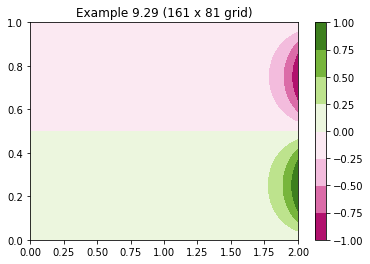

In [6]:
# Let's try test that fine grid again
test = Example929(161,81)

# we will time it
start = time.process_time()
itt, err = GaussSeidel(test)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
plt.show()

## Analysis

After a lot of messing about with lists of the central, east, north, west and south k values and some whole array programming using we have a version of Gauss-Seidel which runs in 9.59 seconds, compared to the 46 seconds taken by the original method, a speed up of 484%. 

We can ammend the code to implement SOR quite simply.



In [7]:
def SOR(mesh,tol=0.5e-7,maxit=10000):
    '''SOR itteration with checkerboarding 
    applied to the grid stored in mesh.  
    We will continue itterating until the difference between
    u^{n+1} and u^n is less than tol. We will also stop if 
    we have done more than maxit itterations.
    
    The solution stored in the mesh.u variable is updated'''
    
    # calculate the optimal value of omega
    lamda = (np.cos(np.pi/mesh.Ni)+np.cos(np.pi/mesh.Nj))**2/4
    omega = 2/(1+np.sqrt(1-lamda))


    # calculate the coefficients
    beta = mesh.Delta_x()/mesh.Delta_y()
    beta_sq = beta**2
    C_beta = 1/(2*(1+beta_sq))
    
    # initialise u_new 
    u_new = mesh.u.copy()
    
    # build the list of k values    
    offset = mesh.u.shape[1] # how far away are j+1 and j-1

    # create some empty lists
    centre = []; north = []; east = []; south=[]; west = []  
    # loop over all the interior points
    for j in range(1,mesh.Nj-1):
        for i in range(1,mesh.Ni-1):
            k=i+offset*j  # calculate the k value
            # save the south, west, centre, east and north points
            centre.append(k)
            north.append(k+offset)
            east.append(k+1)
            south.append(k-offset)
            west.append(k-1)

    # itteration
    for it in range(maxit):
        
        # red squares [::2] means from 0 to n in steps of 2, remember
        # we are taking alternate values from the lists centre, east,
        # north, west and south and using them as indicies into the 
        # u_new array.
        u_new.flat[centre[::2]] = (1-omega) * u_new.flat[centre[::2]] + \
                                    omega * C_beta*(u_new.flat[north[::2]]+ \
                                    u_new.flat[south[::2]]+ \
                                    beta_sq*(u_new.flat[east[::2]]+ \
                                             u_new.flat[west[::2]]))
        
        # black squares [1::2] means from 1 to n in steps of 2
        u_new.flat[centre[1::2]] = (1-omega) * u_new.flat[centre[1::2]] + \
                                    omega * C_beta*(u_new.flat[north[1::2]]+ \
                                    u_new.flat[south[1::2]]+ \
                                    beta_sq*(u_new.flat[east[1::2]]+ \
                                             u_new.flat[west[1::2]]))

        # compute the difference between the new and old solutions
        err = np.max(mesh.u-u_new)
        
        # update the solution
        mesh.u = np.copy(u_new)
        
        # converged?
        if err < tol:
            break
    
    if it+1 == maxit:
        print('Checkerboard Gauss-Seidel itteration failed to converge, error = {}'.format(err))
    
    return it+1, err # return the number of itterations and the final residual

Solver took 1.21 seconds.
Converged after 258 itterations, final residual is 4.765657729555173e-08


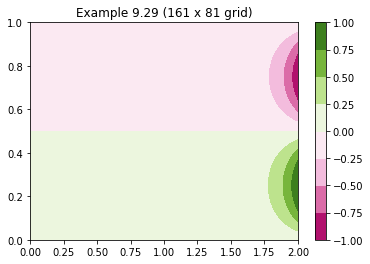

In [8]:
# Let's try test that fine grid again
test2 = Example929(161,81)

# we will time it
start = time.process_time()
itt, err = SOR(test2)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test2.x,test2.y,test2.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test2.Ni} x {test2.Nj} grid)')
plt.show()

### Analysis

The checkerboard version of the SOR solver runs in 1.16 seconds, five times faster than the point SOR version. Still not as fast as the Jacobi solver (in terms of run time) but never the less very impressive.  

Given this speed we can try a finer grid

Solver took 11.6 seconds.
Converged after 500 itterations, final residual is 4.983336954200723e-08


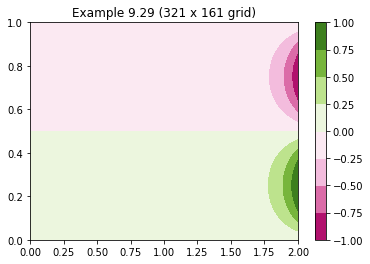

In [9]:
# Let's try test that fine grid again
test3 = Example929(321,161)

# we will time it
start = time.process_time()
itt, err = SOR(test3)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))
print('Converged after {} itterations, final residual is {}'.format(itt,err))

# plot the solution
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('PiYG')
cf = ax1.contourf(test3.x,test3.y,test3.u,cmap=cmap)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Example 9.29 ({test3.Ni} x {test3.Nj} grid)')
plt.show()

## Line SOR
It is possible to use a technique called line-SOR to get the benefits of SOR and the processor pipeline.  

Here we take a weighted average of the old and new values of u (as in SOR) but include one additional value at the new time level: $$u_O^{n+1}=(1-\omega)u_O^n+\frac{\omega}{2(1+\beta^2)}(u_E^{n+1}+u_W^{n+1}+\beta^2(u_N^n+u_S^{n+1})).$$

This means we now have a problem as we need to know $$u_E^{n+1},\ u_O^{n+1},\text {and }$u_W^{n+1}$$ at the new time level.  We thus have a system of linear equations to solve in each row.  Beacuse this is tri-diagonal it can be solved quickly and we get the benefits of pipeline speed and the accelerated convergence.  We will find out more about it when we look at parabolic equations.

